In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from time_series_utils import WindowGen   

In [8]:
cols= ['time','missing_info','job_id','task_index','machineid','event_type','user','sch_class',
       'priority','cpu_req','mem_req','disk_req','machine_restr']

n_files = 200
try:
    df = pd.read_csv(f'data_{n_files}.zip',index_col=0)
except:
    print('Loading new data...')
    data= pd.DataFrame()
    for i in range(n_files):
        try:
            df = pd.read_csv('data/'+sorted(os.listdir('data'))[i],names=cols)
            df[['job_id','task_index']] = df[['job_id','task_index']].astype(str)
            df['n_tasks'] = df['job_id']+df['task_index']
            df['slot']=df['time']//120000000
            df = df[['slot','n_tasks','cpu_req','mem_req']].drop_duplicates('n_tasks')
            df = df.groupby('slot',as_index=True).agg({"n_tasks": 'count',"cpu_req": np.sum,'mem_req': np.sum})
            data = pd.concat([data,df],axis=0)
        except:
            continue
    df = data.reset_index(drop=True)
    df.to_csv(f'data_{n_files}.zip')
    print('Data is loaded.')


In [9]:
df

,n_tasks,cpu_req,mem_req
0,346,13.939781,12.503087
1,442,15.958219,13.809937
2,1183,30.124597,29.633960
3,106,6.233949,3.070520
4,920,10.904767,11.287415
...,...,...,...
8488,406,9.528836,4.151624
8489,2483,69.594540,34.237972
8490,2270,70.014075,18.984662
8491,971,11.598564,6.873451


<AxesSubplot:ylabel='mem_req'>

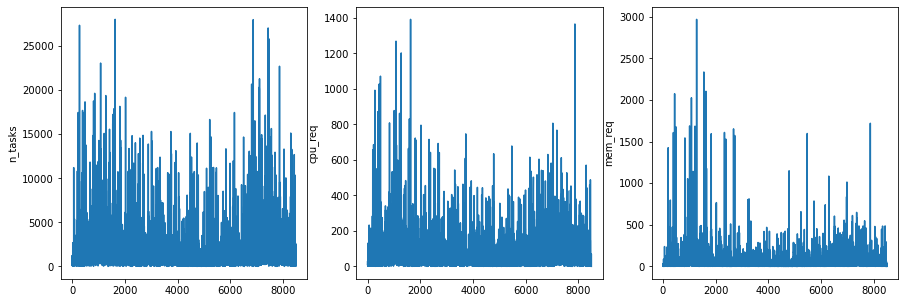

In [10]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
sns.lineplot(ax= axes[0], x=df.index,y=df['n_tasks'])
sns.lineplot(ax= axes[1], x=df.index,y=df['cpu_req'])
sns.lineplot(ax= axes[2], x=df.index,y=df['mem_req'])

In [11]:
# Data Transformations
df['n_tasks'] = np.log(df['n_tasks'])

In [12]:
def norm(output,input= input):
    mean = input.mean()
    std = input.std()
    return (output-mean)/std

In [13]:
# Split data into train and test sets
n_samples = df.shape[0]
split = 0.1

train_df = df[:round(n_samples*(1-split))]
test_df = df[:round(n_samples*(1-split))]

In [14]:
train_df = train_df.apply(norm, axis=1, input=train_df)
test_df = test_df.apply(norm, axis=1, input=train_df)

In [15]:
# Reshape data according to a given window
step = 60
window = WindowGen(step)

X_train, y_train = window(train_df,column_names=['n_tasks'],label_names=['n_tasks'])
X_test, y_test = window(test_df,column_names=['n_tasks'],label_names=['n_tasks'])

In [16]:
X_train, y_train = window(train_df)

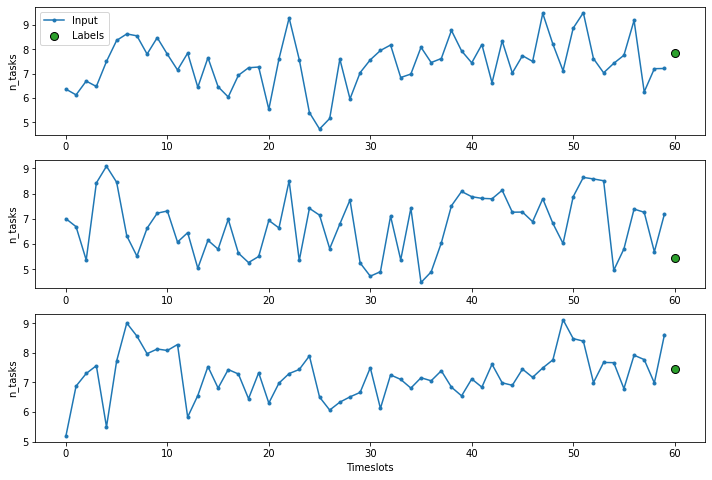

In [38]:
window.plot(plt_col='n_tasks')

In [9]:
import tensorflow as tf
import tensorflow_addons as tfa
import datetime
from tensorflow.keras import regularizers
import keras_tuner as kt
from tuner import HpModel

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [11]:
# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    './tmp/checkpoint',
    save_weights_only=True,
    monitor='loss',
    save_best_only=True)
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# early_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,
#     patience=30)

loss = tf.keras.losses.MeanSquaredError()
EPOCHS = 1000

In [15]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(step,1)))
    LSTM1 = hp.Int('units1', min_value=50, max_value=55, step=1)
    LSTM2 = hp.Int('units2', min_value=20, max_value=55, step=1)
    model.add(tf.keras.layers.LSTM(units=LSTM1,return_sequences=True))
    model.add(tf.keras.layers.LSTM(units=LSTM2))
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [16]:
model = HpModel(model=model_builder,loss=loss,epochs=EPOCHS)

tuner = kt.RandomSearch(objective=kt.Objective("val_loss", "min"), max_trials=5, hypermodel=model,
    directory="results", project_name="custom_training", overwrite=True,)

In [17]:
tuner.search(x=X_train, y=y_train, validation_data=(X_test, y_test))

Trial 5 Complete [00h 02m 48s]
val_loss: 0.030732452869415283

Best val_loss So Far: 0.0035495776683092117
Total elapsed time: 00h 15m 00s
INFO:tensorflow:Oracle triggered exit


In [18]:
best_hps = tuner.get_best_hyperparameters(5)

In [26]:
for i in best_hps:
    print(i.values)

{'units1': 54, 'units2': 21, 'batch_size': 3000, 'learning_rate': 0.004619604548269685}
{'units1': 52, 'units2': 24, 'batch_size': 2000, 'learning_rate': 0.0021291840426046296}
{'units1': 52, 'units2': 24, 'batch_size': 2000, 'learning_rate': 0.001}
{'units1': 53, 'units2': 24, 'batch_size': 3000, 'learning_rate': 0.0005832353636090387}
{'units1': 52, 'units2': 23, 'batch_size': 1000, 'learning_rate': 0.00016468966822474475}


In [30]:
def model_builder():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(step,1)))
    model.add(tf.keras.layers.LSTM(units=54,return_sequences=True))
    model.add(tf.keras.layers.LSTM(units=54))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.004519604548),
                  loss = tf.keras.losses.MeanSquaredError())
    
    return model
model = model_builder()

In [31]:
model.fit(x=X_train,y=y_train, validation_data=(X_test,y_test),epochs=1500,batch_size=3000,
          callbacks=[model_checkpoint_callback])

Epoch 1/1500
3/3 [==============================] - 3s 378ms/step - loss: 0.7036 - val_loss: 0.4164
Epoch 2/1500
3/3 [==============================] - 0s 84ms/step - loss: 0.4257 - val_loss: 0.4497
Epoch 3/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.4372 - val_loss: 0.4029
Epoch 4/1500
3/3 [==============================] - 0s 85ms/step - loss: 0.4049 - val_loss: 0.4151
Epoch 5/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.4114 - val_loss: 0.3985
Epoch 6/1500
3/3 [==============================] - 0s 83ms/step - loss: 0.3982 - val_loss: 0.4004
Epoch 7/1500
3/3 [==============================] - 0s 71ms/step - loss: 0.4010 - val_loss: 0.3989
Epoch 8/1500
3/3 [==============================] - 0s 83ms/step - loss: 0.3968 - val_loss: 0.3932
Epoch 9/1500
3/3 [==============================] - 0s 85ms/step - loss: 0.3932 - val_loss: 0.3946
Epoch 10/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.3942 - val_loss: 0.3915
Epoch 11

Epoch 83/1500
3/3 [==============================] - 0s 99ms/step - loss: 0.3553 - val_loss: 0.3541
Epoch 84/1500
3/3 [==============================] - 0s 87ms/step - loss: 0.3548 - val_loss: 0.3540
Epoch 85/1500
3/3 [==============================] - 0s 85ms/step - loss: 0.3542 - val_loss: 0.3536
Epoch 86/1500
3/3 [==============================] - 0s 84ms/step - loss: 0.3540 - val_loss: 0.3536
Epoch 87/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.3544 - val_loss: 0.3525
Epoch 88/1500
3/3 [==============================] - 0s 91ms/step - loss: 0.3533 - val_loss: 0.3525
Epoch 89/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.3546 - val_loss: 0.3527
Epoch 90/1500
3/3 [==============================] - 0s 90ms/step - loss: 0.3527 - val_loss: 0.3525
Epoch 91/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.3529 - val_loss: 0.3517
Epoch 92/1500
3/3 [==============================] - 0s 88ms/step - loss: 0.3516 - val_loss: 0.3507


3/3 [==============================] - 0s 67ms/step - loss: 0.3140 - val_loss: 0.3090
Epoch 165/1500
3/3 [==============================] - 0s 90ms/step - loss: 0.3092 - val_loss: 0.3092
Epoch 166/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.3116 - val_loss: 0.3093
Epoch 167/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.3096 - val_loss: 0.3104
Epoch 168/1500
3/3 [==============================] - 0s 70ms/step - loss: 0.3106 - val_loss: 0.3092
Epoch 169/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.3111 - val_loss: 0.3072
Epoch 170/1500
3/3 [==============================] - 0s 93ms/step - loss: 0.3091 - val_loss: 0.3091
Epoch 171/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.3128 - val_loss: 0.3086
Epoch 172/1500
3/3 [==============================] - 0s 92ms/step - loss: 0.3078 - val_loss: 0.3112
Epoch 173/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.3114 - val_loss: 0.3044
Epoch

3/3 [==============================] - 0s 87ms/step - loss: 0.2432 - val_loss: 0.2415
Epoch 246/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.2476 - val_loss: 0.2372
Epoch 247/1500
3/3 [==============================] - 0s 90ms/step - loss: 0.2415 - val_loss: 0.2396
Epoch 248/1500
3/3 [==============================] - 0s 87ms/step - loss: 0.2395 - val_loss: 0.2418
Epoch 249/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.2425 - val_loss: 0.2383
Epoch 250/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.2401 - val_loss: 0.2395
Epoch 251/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.2443 - val_loss: 0.2424
Epoch 252/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.2413 - val_loss: 0.2420
Epoch 253/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.2406 - val_loss: 0.2399
Epoch 254/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.2444 - val_loss: 0.2407
Epoch

3/3 [==============================] - 0s 84ms/step - loss: 0.1632 - val_loss: 0.1630
Epoch 327/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.1637 - val_loss: 0.1629
Epoch 328/1500
3/3 [==============================] - 0s 92ms/step - loss: 0.1603 - val_loss: 0.1569
Epoch 329/1500
3/3 [==============================] - 0s 87ms/step - loss: 0.1589 - val_loss: 0.1577
Epoch 330/1500
3/3 [==============================] - 0s 100ms/step - loss: 0.1579 - val_loss: 0.1650
Epoch 331/1500
3/3 [==============================] - 0s 69ms/step - loss: 0.1633 - val_loss: 0.1554
Epoch 332/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.1627 - val_loss: 0.1661
Epoch 333/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.1619 - val_loss: 0.1732
Epoch 334/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.1698 - val_loss: 0.1799
Epoch 335/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.1761 - val_loss: 0.1605
Epoc

3/3 [==============================] - 0s 67ms/step - loss: 0.1195 - val_loss: 0.1228
Epoch 408/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.1236 - val_loss: 0.1207
Epoch 409/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.1239 - val_loss: 0.1160
Epoch 410/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.1190 - val_loss: 0.1097
Epoch 411/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.1096 - val_loss: 0.1058
Epoch 412/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.1073 - val_loss: 0.1024
Epoch 413/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.1044 - val_loss: 0.1132
Epoch 414/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.1089 - val_loss: 0.0982
Epoch 415/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.1028 - val_loss: 0.1043
Epoch 416/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.1035 - val_loss: 0.0974
Epoch

3/3 [==============================] - 0s 86ms/step - loss: 0.0582 - val_loss: 0.0555
Epoch 489/1500
3/3 [==============================] - 0s 89ms/step - loss: 0.0567 - val_loss: 0.0547
Epoch 490/1500
3/3 [==============================] - 0s 84ms/step - loss: 0.0562 - val_loss: 0.0531
Epoch 491/1500
3/3 [==============================] - 0s 85ms/step - loss: 0.0550 - val_loss: 0.0533
Epoch 492/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0554 - val_loss: 0.0561
Epoch 493/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0558 - val_loss: 0.0557
Epoch 494/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0568 - val_loss: 0.0533
Epoch 495/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0553 - val_loss: 0.0592
Epoch 496/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0572 - val_loss: 0.0536
Epoch 497/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0571 - val_loss: 0.0532
Epoch

3/3 [==============================] - 0s 92ms/step - loss: 0.0377 - val_loss: 0.0700
Epoch 570/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0662 - val_loss: 0.0700
Epoch 571/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0694 - val_loss: 0.0711
Epoch 572/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0685 - val_loss: 0.0698
Epoch 573/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.0697 - val_loss: 0.0627
Epoch 574/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.0675 - val_loss: 0.0774
Epoch 575/1500
3/3 [==============================] - 0s 69ms/step - loss: 0.0728 - val_loss: 0.0619
Epoch 576/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.0664 - val_loss: 0.0649
Epoch 577/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0641 - val_loss: 0.0605
Epoch 578/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0611 - val_loss: 0.0546
Epoch

3/3 [==============================] - 0s 66ms/step - loss: 0.0311 - val_loss: 0.0295
Epoch 651/1500
3/3 [==============================] - 0s 87ms/step - loss: 0.0300 - val_loss: 0.0281
Epoch 652/1500
3/3 [==============================] - 0s 83ms/step - loss: 0.0289 - val_loss: 0.0281
Epoch 653/1500
3/3 [==============================] - 0s 90ms/step - loss: 0.0285 - val_loss: 0.0271
Epoch 654/1500
3/3 [==============================] - 0s 84ms/step - loss: 0.0270 - val_loss: 0.0250
Epoch 655/1500
3/3 [==============================] - 0s 83ms/step - loss: 0.0254 - val_loss: 0.0253
Epoch 656/1500
3/3 [==============================] - 0s 85ms/step - loss: 0.0247 - val_loss: 0.0241
Epoch 657/1500
3/3 [==============================] - 0s 101ms/step - loss: 0.0246 - val_loss: 0.0241
Epoch 658/1500
3/3 [==============================] - 0s 87ms/step - loss: 0.0240 - val_loss: 0.0231
Epoch 659/1500
3/3 [==============================] - 0s 82ms/step - loss: 0.0230 - val_loss: 0.0224
Epoc

3/3 [==============================] - 0s 66ms/step - loss: 0.0182 - val_loss: 0.0179
Epoch 732/1500
3/3 [==============================] - 0s 86ms/step - loss: 0.0175 - val_loss: 0.0173
Epoch 733/1500
3/3 [==============================] - 0s 84ms/step - loss: 0.0173 - val_loss: 0.0160
Epoch 734/1500
3/3 [==============================] - 0s 83ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 735/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.0166 - val_loss: 0.0155
Epoch 736/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0160 - val_loss: 0.0145
Epoch 737/1500
3/3 [==============================] - 0s 89ms/step - loss: 0.0153 - val_loss: 0.0155
Epoch 738/1500
3/3 [==============================] - 0s 86ms/step - loss: 0.0151 - val_loss: 0.0167
Epoch 739/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0162 - val_loss: 0.0155
Epoch 740/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0157 - val_loss: 0.0162
Epoch

3/3 [==============================] - 0s 85ms/step - loss: 0.0118 - val_loss: 0.0110
Epoch 813/1500
3/3 [==============================] - 0s 84ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 814/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0125 - val_loss: 0.0116
Epoch 815/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0120 - val_loss: 0.0122
Epoch 816/1500
3/3 [==============================] - 0s 89ms/step - loss: 0.0112 - val_loss: 0.0123
Epoch 817/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0119 - val_loss: 0.0121
Epoch 818/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0123 - val_loss: 0.0103
Epoch 819/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 820/1500
3/3 [==============================] - 0s 95ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 821/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch

3/3 [==============================] - 0s 67ms/step - loss: 0.0094 - val_loss: 0.0083
Epoch 894/1500
3/3 [==============================] - 0s 87ms/step - loss: 0.0090 - val_loss: 0.0075
Epoch 895/1500
3/3 [==============================] - 0s 84ms/step - loss: 0.0084 - val_loss: 0.0089
Epoch 896/1500
3/3 [==============================] - 0s 85ms/step - loss: 0.0083 - val_loss: 0.0086
Epoch 897/1500
3/3 [==============================] - 0s 64ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 898/1500
3/3 [==============================] - 0s 69ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 899/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 900/1500
3/3 [==============================] - 0s 69ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 901/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 902/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.0096 - val_loss: 0.0080
Epoch

3/3 [==============================] - 0s 85ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 975/1500
3/3 [==============================] - 0s 83ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 976/1500
3/3 [==============================] - 0s 83ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 977/1500
3/3 [==============================] - 0s 71ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 978/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 979/1500
3/3 [==============================] - 0s 92ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 980/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 981/1500
3/3 [==============================] - 0s 93ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 982/1500
3/3 [==============================] - 0s 84ms/step - loss: 0.0045 - val_loss: 0.0049
Epoch 983/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch

3/3 [==============================] - 0s 67ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 1055/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 1056/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 1057/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 1058/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 1059/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 1060/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 1061/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.0054 - val_loss: 0.0065
Epoch 1062/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 1063/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0053 - val_loss: 0.0

3/3 [==============================] - 0s 69ms/step - loss: 0.0219 - val_loss: 0.0243
Epoch 1135/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0223 - val_loss: 0.0221
Epoch 1136/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.0217 - val_loss: 0.0192
Epoch 1137/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.0234 - val_loss: 0.0197
Epoch 1138/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.0188 - val_loss: 0.0199
Epoch 1139/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0199 - val_loss: 0.0209
Epoch 1140/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0207 - val_loss: 0.0171
Epoch 1141/1500
3/3 [==============================] - 0s 70ms/step - loss: 0.0183 - val_loss: 0.0208
Epoch 1142/1500
3/3 [==============================] - 0s 69ms/step - loss: 0.0191 - val_loss: 0.0177
Epoch 1143/1500
3/3 [==============================] - 0s 69ms/step - loss: 0.0177 - val_loss: 0.0

3/3 [==============================] - 0s 67ms/step - loss: 0.0171 - val_loss: 0.0195
Epoch 1215/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.0215 - val_loss: 0.0260
Epoch 1216/1500
3/3 [==============================] - 0s 64ms/step - loss: 0.0325 - val_loss: 0.0372
Epoch 1217/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.0324 - val_loss: 0.0279
Epoch 1218/1500
3/3 [==============================] - 0s 64ms/step - loss: 0.0282 - val_loss: 0.0325
Epoch 1219/1500
3/3 [==============================] - 0s 65ms/step - loss: 0.0294 - val_loss: 0.0277
Epoch 1220/1500
3/3 [==============================] - 0s 71ms/step - loss: 0.0303 - val_loss: 0.0281
Epoch 1221/1500
3/3 [==============================] - 0s 64ms/step - loss: 0.0276 - val_loss: 0.0307
Epoch 1222/1500
3/3 [==============================] - 0s 66ms/step - loss: 0.0308 - val_loss: 0.0315
Epoch 1223/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0273 - val_loss: 0.0

3/3 [==============================] - 0s 70ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 1295/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 1296/1500
3/3 [==============================] - 0s 69ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 1297/1500
3/3 [==============================] - 0s 89ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 1298/1500
3/3 [==============================] - 0s 88ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 1299/1500
3/3 [==============================] - 0s 104ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 1300/1500
3/3 [==============================] - 0s 89ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 1301/1500
3/3 [==============================] - 0s 89ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 1302/1500
3/3 [==============================] - 0s 86ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 1303/1500
3/3 [==============================] - 0s 69ms/step - loss: 0.0019 - val_loss: 0.

3/3 [==============================] - 0s 68ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 1375/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 1376/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 1377/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 1378/1500
3/3 [==============================] - 0s 69ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 1379/1500
3/3 [==============================] - 0s 70ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 1380/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 1381/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 1382/1500
3/3 [==============================] - 0s 70ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 1383/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0015 - val_loss: 0.0

3/3 [==============================] - 0s 71ms/step - loss: 0.0498 - val_loss: 0.0413
Epoch 1455/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0567 - val_loss: 0.0479
Epoch 1456/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0496 - val_loss: 0.0512
Epoch 1457/1500
3/3 [==============================] - 0s 69ms/step - loss: 0.0447 - val_loss: 0.0425
Epoch 1458/1500
3/3 [==============================] - 0s 69ms/step - loss: 0.0420 - val_loss: 0.0538
Epoch 1459/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0493 - val_loss: 0.0513
Epoch 1460/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0475 - val_loss: 0.0503
Epoch 1461/1500
3/3 [==============================] - 0s 68ms/step - loss: 0.0504 - val_loss: 0.0442
Epoch 1462/1500
3/3 [==============================] - 0s 70ms/step - loss: 0.0417 - val_loss: 0.0308
Epoch 1463/1500
3/3 [==============================] - 0s 67ms/step - loss: 0.0339 - val_loss: 0.0

In [32]:
model.load_weights('./tmp/checkpoint')

In [33]:
fin = model.predict(X_train)

In [34]:
m = tf.keras.metrics.MeanSquaredError()
m.update_state(fin,y_train)
print('Root mean squared loss is: ', m.result().numpy())

Root mean squared loss is:  0.0014312554


In [35]:
# y_train=y_train.reshape(-1)
# y_test=y_test.reshape(-1)
# fin= fin.reshape(-1)

m = tfa.metrics.r_square.RSquare()
m.update_state(fin, y_train)
print('R-squared is: ', m.result().numpy())

InvalidArgumentError: in user code:

    File "C:\Users\anton\AppData\Local\Programs\anaconda3\envs\tf2\lib\site-packages\tensorflow_addons\metrics\r_square.py", line 130, in update_state  *
        self.sum.assign_add(tf.reduce_sum(weighted_y_true, axis=0))

    InvalidArgumentError: Cannot update variable with shape [] using a Tensor with shape [1], shapes must be equal. [Op:AssignAddVariableOp]


In [36]:
fin

array([[-0.87499315],
       [ 1.004493  ],
       [ 0.557678  ],
       ...,
       [-1.1706197 ],
       [-1.1159264 ],
       [-1.214663  ]], dtype=float32)

In [37]:
y_train

<tf.Tensor: shape=(7584, 1, 1), dtype=float64, numpy=
array([[[-0.87796194]],

       [[ 0.98357014]],

       [[ 0.55097215]],

       ...,

       [[-1.13136509]],

       [[-1.1546944 ]],

       [[-1.14046995]]])>

In [ ]:
y_train_e=np.exp(y_train)
fin_e=np.exp(fin)

In [ ]:
y_pred = pd.DataFrame({'slot':[i for i in range(len(fin))],'Class':['Prediction' for i in range(len(fin))],'mem_req':fin_e})
y_true = pd.DataFrame({'slot':[i for i in range(len(fin))],'Class':['True' for i in range(len(fin))],'mem_req':y_train_e})
final = pd.concat([y_pred,y_true], axis=0)

In [ ]:
sns.lineplot(x='slot',y= 'mem_req', ci=None, 
             hue='Class', data=final.reset_index())